In [1]:
#import packages
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, roc_auc_score, roc_curve
import xgboost as xgb

In [67]:
#import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/jackepstein/Documents/GitHub/wildfires-1001/code/functions/')
data_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/data'
code_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/code'

# Pull in main data frame

In [68]:
#pull in the target data frame and weather dictionary 
#make sure to change the pkl file name if needed
target_dict = {}
target_df = gpd.GeoDataFrame()
for i in np.arange(1, 3):
    target_dict[i] = pd.read_pickle(os.path.join(data_dir, f'clean_data/target_df_final_1123_newtargets_{i}.pkl')) 
    target_df = target_df.append(target_dict[i])


weather_dict_path = os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl')

In [69]:
#load the naming dictionary
with open(weather_dict_path, 'rb') as handle:
    rename_dict = pickle.load(handle)

In [70]:
#rename the columns based on this dictionary
target_df.rename(columns = rename_dict, inplace = True)

In [71]:
#create lists of columns to drop and what our targets are
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','NAME','GRID_AREA','COUNTY_ARE','COUNTY_AREA',
                'geometry', 'adj_fire_count','adj_fire_bcount', 'Fire_area','Index','index']
bad_features = ['hist_p_time_1m', 'total_fire_days', 'hist_p_time_1y','month_id_old']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

In [74]:
#turn class targets into integers
target_df['Y_bin_new_fire_month'] = target_df['Y_bin_new_fire_month'].astype(int)
target_df['Y_max_new_fire_size_month'] = target_df['Y_max_new_fire_size_month'].astype(int)
target_df['Y_count_new_fires_month'] = target_df['Y_count_new_fires_month'].astype(int)

# Split training and testing data

In [75]:
#generate training data set
#pre 2016
train_data = target_df[target_df['YEAR']<=2016]
X_train = train_data.drop('YEAR', axis = 1)
#drop columns not used for modeling
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train_cl = train_data[['Y_bin_new_fire_month']]
Y_train_cl_size = train_data[['Y_max_new_fire_size_month']]

#generate testing data set - same logic as above
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_cl = test_data[['Y_bin_new_fire_month']]
Y_test_cl_size = test_data[['Y_max_new_fire_size_month']]

In [76]:
Y_test_cl.groupby(['Y_bin_new_fire_month'])['Y_bin_new_fire_month'].count()

Y_bin_new_fire_month
0    4176
1     576
Name: Y_bin_new_fire_month, dtype: int64

In [77]:
Y_test_cl_size.groupby(['Y_max_new_fire_size_month'])['Y_max_new_fire_size_month'].count()

Y_max_new_fire_size_month
0    4176
1     298
2     117
3     161
Name: Y_max_new_fire_size_month, dtype: int64

In [78]:
#check for any null values

#null vals array
null = np.zeros(len(X_train.columns))

for i in range(len(X_train.columns)):
    null[i] = X_train.loc[X_train[X_train.columns[i]].isna()].shape[0]
    
np.sum(null)

0.0

In [79]:
y_test_cl_arr = Y_test_cl.to_numpy().ravel()

# Attempting Gradient Boosting

## First attempt

In [12]:
#starting with max depth=2 and 1,000 n_estimators
n_est_lim = 1000
gbc = GradientBoostingClassifier(n_estimators = n_est_lim, max_depth = 2)
gbc.fit(X_train, Y_train_cl.to_numpy().ravel())

GradientBoostingClassifier(max_depth=2, n_estimators=1000)

In [64]:
preds_gbc = gbc.predict(X_test)
preds_gbc_prob = gbc.predict_proba(X_test)


#plot confusion
print(confusion_matrix(y_test_cl_arr,preds_gbc))

#get precision and recall scores
print(roc_auc_score(y_test_cl_arr, preds_gbc))
print(classification_report(y_test_cl_arr, preds_gbc))

[[4004  172]
 [ 411  165]]
0.6226352969348659
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4176
           1       0.49      0.29      0.36       576

    accuracy                           0.88      4752
   macro avg       0.70      0.62      0.65      4752
weighted avg       0.86      0.88      0.86      4752



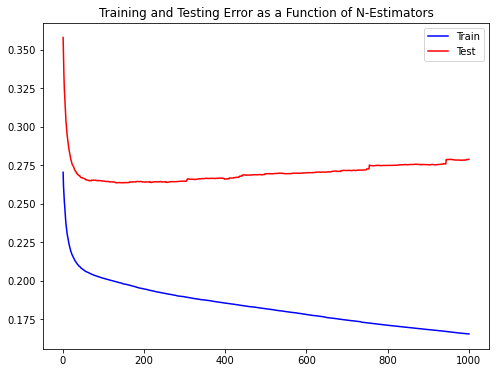

In [41]:
#plot seeing if we overfit

#define a log loss function
def LogLossP(Pt, Yt):
    return -1*((Yt==1)*np.log(Pt)+(Yt==0)*np.log(1-Pt)).mean()

#get the probabilities at each iteration
p_train = gbc.staged_predict_proba(X_train)
p_test = gbc.staged_predict_proba(X_test)

#initiate lists to store log loss
ll_train = []
ll_test = []

#loop through each calculating log loss at each iterative tree
for p in p_train:
    ll_train.append(LogLossP(p[:, 1], Y_train_cl.to_numpy().ravel()))
    
for p in p_test:
    ll_test.append(LogLossP(p[:, 1], Y_test_cl.to_numpy().ravel()))
    
#plot this
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, n_est_lim + 1), ll_train, 'b-', label='Train')
plt.plot(np.arange(1, n_est_lim + 1), ll_test, 'r-', label='Test')
plt.title('Training and Testing Error as a Function of N-Estimators')
plt.legend()

## 2nd attempt

In [15]:
#starting with max depth=2 trying 200 trees
gbc_2 = GradientBoostingClassifier(n_estimators = 200, max_depth = 2)
gbc_2.fit(X_train, Y_train_cl.to_numpy().ravel())

GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [65]:
#checking for fewer trees
preds_gbc_2 = gbc_2.predict(X_test)
preds_gbc_2_probs = gbc_2.predict_proba(X_test)

#plot confusion
print(confusion_matrix(y_test_cl_arr,preds_gbc_2))

#get precision and recall scores
print(roc_auc_score(y_test_cl_arr, preds_gbc_2))
print(classification_report(y_test_cl_arr, preds_gbc_2))

[[4116   60]
 [ 456  120]]
0.5969827586206896
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4176
           1       0.67      0.21      0.32       576

    accuracy                           0.89      4752
   macro avg       0.78      0.60      0.63      4752
weighted avg       0.87      0.89      0.87      4752



# Attempt with XGBoost

In [17]:
#binary classification
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, Y_train_cl.to_numpy().ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
xgb_preds = xgb_model.predict(X_test)
xgb_pred_pr = xgb_model.predict_proba(X_test)

#plot confusion
print(confusion_matrix(y_test_cl_arr,xgb_preds))

#get precision and recall scores
print(roc_auc_score(y_test_cl_arr, xgb_preds))
print(classification_report(y_test_cl_arr, xgb_preds))

[[4041  135]
 [ 433  143]]
0.6079681513409961
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4176
           1       0.51      0.25      0.33       576

    accuracy                           0.88      4752
   macro avg       0.71      0.61      0.63      4752
weighted avg       0.86      0.88      0.86      4752



In [24]:
#binary classification -- trying more trees

xgb1000_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=n_est_lim)
xgb1000_model.fit(X_train, Y_train_cl.to_numpy().ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
xgb1000_preds = xgb1000_model.predict(X_test)
xgb1000_pred_pr = xgb1000_model.predict_proba(X_test)

#plot confusion
print(confusion_matrix(y_test_cl_arr,xgb1000_preds))

#get precision and recall scores
print(classification_report(y_test_cl_arr, xgb1000_preds))

[[4037  139]
 [ 431  145]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4176
           1       0.51      0.25      0.34       576

    accuracy                           0.88      4752
   macro avg       0.71      0.61      0.64      4752
weighted avg       0.86      0.88      0.86      4752



## Evaluation

In [27]:
#plot an auc curve
auc_1000 = roc_auc_score(y_test_cl_arr,preds_gbc_prob[:,1])
auc_200 = roc_auc_score(y_test_cl_arr,preds_gbc_2_probs[:,1])
auc_xgb = roc_auc_score(y_test_cl_arr, xgb_pred_pr[:,1])
auc_xgb_1000 = roc_auc_score(y_test_cl_arr, xgb1000_pred_pr[:,1])

#get rocs
fpr_1000, tpr_1000, thresh_1000 = roc_curve(y_test_cl_arr,preds_gbc_prob[:,1])
fpr_200, tpr_200, thresh_200 = roc_curve(y_test_cl_arr,preds_gbc_2_probs[:,1])
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test_cl_arr,xgb_pred_pr[:,1])
fpr_xgb_1000, tpr_xgb_1000, thresh_xgb_1000 = roc_curve(y_test_cl_arr, xgb1000_pred_pr[:,1])

aucs = [auc_1000, auc_200, auc_xgb, auc_xgb_1000]
fprs = [fpr_1000, fpr_200, fpr_xgb, fpr_xgb_1000]
tprs = [tpr_1000, tpr_200, tpr_xgb, tpr_xgb_1000]
labels = ['1000 trees', '200 trees', 'XGBoost', 'XGBoost-1K']

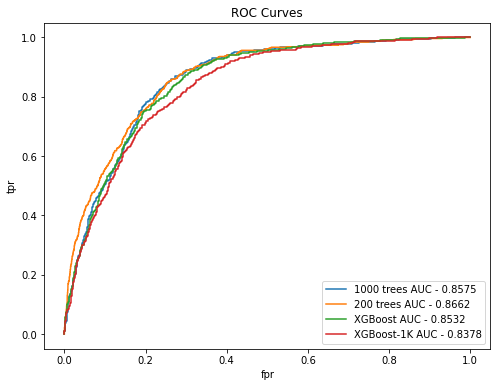

In [28]:
#plot each of the 4 curves
plt.figure(figsize=(8,6))
for fpr, tpr, label, auc in zip(fprs, tprs, labels, aucs):
    labauc = label+" AUC - "+str(round(auc,4))
    plt.plot(fpr, tpr, label=labauc)
    
    
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()    

In [29]:
features_gbc = pd.DataFrame()
features_gbc['feature'] = X_test.columns
features_gbc['feature_score'] = gbc.feature_importances_
features_gbc.sort_values(by=['feature_score'], ascending=False)

,feature,feature_score
70,tot_area_fire_prev_1yr,0.127081
66,hist_fire_area_prop_1m,0.126647
153,2m_tmp_18hrs_10y,0.114703
121,2m_tmp_18hrs_5y,0.067635
69,hist_fire_area_prop_10y,0.037730
...,...,...
135,tot_prcp_6hrs_5y,0.000000
156,leaf_high_veg_12hrs_10y,0.000000
62,hist_bin_10y,0.000000
61,hist_bin_5y,0.000000


## OOB Class Size

In [60]:
#classifying class sizing -- no hyperparameter tuning
gbc_size_oob = GradientBoostingClassifier().fit(X_train, Y_train_cl_size.to_numpy().ravel())
#checking for fewer trees
preds_gbc_oob = gbc_size_oob.predict(X_test)


#plot confusion
print(confusion_matrix(Y_test_cl_size.to_numpy().ravel(),preds_gbc_oob))

#get precision and recall scores
print(classification_report(Y_test_cl_size.to_numpy().ravel(), preds_gbc_oob))

[[4127   18   10   21]
 [ 272   13    8    5]
 [ 108    3    3    3]
 [ 141    7    3   10]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4176
           1       0.32      0.04      0.08       298
           2       0.12      0.03      0.04       117
           3       0.26      0.06      0.10       161

    accuracy                           0.87      4752
   macro avg       0.40      0.28      0.29      4752
weighted avg       0.81      0.87      0.83      4752



In [61]:
unique, counts = np.unique(preds_gbc_oob, return_counts=True)
dict(zip(unique, counts))

{0: 4648, 1: 41, 2: 24, 3: 39}

In [62]:
#classifying class sizing -- XGBoost
xgb_size_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42)
xgb_size_model.fit(X_train, Y_train_cl_size.to_numpy().ravel())

#checking for fewer trees
preds_xgb_size = xgb_size_model.predict(X_test)

#plot confusion
print(confusion_matrix(Y_test_cl_size.to_numpy().ravel(),preds_xgb_size))

#get precision and recall scores
print(classification_report(Y_test_cl_size.to_numpy().ravel(), preds_xgb_size))

[[4142   14    5   15]
 [ 278    9    7    4]
 [ 105    4    4    4]
 [ 143    7    2    9]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      4176
           1       0.26      0.03      0.05       298
           2       0.22      0.03      0.06       117
           3       0.28      0.06      0.09       161

    accuracy                           0.88      4752
   macro avg       0.41      0.28      0.29      4752
weighted avg       0.81      0.88      0.83      4752



In [63]:
unique_x, counts_x = np.unique(preds_xgb_size, return_counts=True)
dict(zip(unique_x, counts_x))

{0: 4668, 1: 34, 2: 18, 3: 32}

# Predicting Class Size on Only Positive Instances

In [109]:
#limit to positives 
pos_df = target_df.loc[target_df['Y_bin_new_fire_month']==1]

#generate training data set
#pre 2016
train_data_pos = pos_df[pos_df['YEAR']<=2016]
X_train_pos = train_data_pos.drop('YEAR', axis = 1)
#drop columns not used for modeling
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_train_pos.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_train_cl_size_pos = train_data_pos[['Y_max_new_fire_size_month']]

#generate testing data set - same logic as above
test_data_pos = pos_df[pos_df['YEAR']>2016]
X_test_pos = test_data_pos.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_test_pos.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_cl_size_pos = test_data_pos[['Y_max_new_fire_size_month']]

In [110]:
Y_train_cl_size_pos = Y_train_cl_size_pos.subtract(1)
Y_test_cl_size_pos = Y_test_cl_size_pos.subtract(1)

In [120]:
#classifying class sizing -- no hyperparameter tuning
gbc_size_pos = GradientBoostingClassifier().fit(X_train_pos, Y_train_cl_size_pos.to_numpy().ravel())
#checking for fewer trees
preds_gbc_pos = gbc_size_pos.predict(X_test_pos)

In [121]:
#plot confusion
print(confusion_matrix(Y_test_cl_size_pos.to_numpy().ravel(),preds_gbc_pos))

#get precision and recall scores
print(classification_report(Y_test_cl_size_pos.to_numpy().ravel(),preds_gbc_pos))

[[221  39  38]
 [ 66  22  29]
 [ 71  21  69]]
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       298
           1       0.27      0.19      0.22       117
           2       0.51      0.43      0.46       161

    accuracy                           0.54       576
   macro avg       0.46      0.45      0.45       576
weighted avg       0.52      0.54      0.52       576



In [40]:
#send best to Git 

gbc1_load_path = os.path.join(code_dir, 'model_dev/GBCbin_1000trees_1123JE')
pickle.dump(gbc, open(gbc1_load_path, "wb"))

gbc3_load_path = os.path.join(code_dir, 'model_dev/GBCsize_OOB_1123JE')
pickle.dump(gbc_size_oob, open(gbc3_load_path, "wb"))